In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file

In [2]:
allNs = list(np.arange(8, 150, 8))
meanerror_3R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
meanerror_3Ri = []
meanerror_B2i = []
meanerror_E2i = []
for N in allNs:
    L = 20
    dx = L/N
    FD = FD_file.FD_Class(dx, periodic_boundary=False)
    xyz = np.arange(-L/2, L/2, dx)[:N]
    xyz = xyz.astype('float128')
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])
    loc = int(N/2), int(N/2), int(N/2)

    gamma = 4/3  #dust: 1, radiation: 4/3
    p1 = (2-gamma)/(2*gamma)
    p2 = (2+gamma)/(4*gamma)
    s = np.sqrt((2 - gamma)*(3*gamma-2))

    t = 1.5
    gdown = np.array([[(t**(2*p1))*Box_ones,      (t**(2*p1))*s*z/(2*gamma),                    Box_zero],
                      [(t**(2*p1))*s*z/(2*gamma), (t**(2*p2))+(t**(2*p1))*((s*z/(2*gamma))**2), Box_zero],
                      [Box_zero,                  Box_zero,                                     (t**(2*p2))*Box_ones]])
    gdown4 = np.array([[-Box_ones, Box_zero, Box_zero, Box_zero],
                       [Box_zero, gdown[0,0], gdown[0,1], gdown[0,2]],
                       [Box_zero, gdown[1,0], gdown[1,1], gdown[1,2]],
                       [Box_zero, gdown[2,0], gdown[2,1], gdown[2,2]]])
    nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])

    Kdown = (-1/2)*np.array([[2*p1*(t**(2*p1-1))*Box_ones,      2*p1*(t**(2*p1-1))*s*z/(2*gamma),                           Box_zero],
                             [2*p1*(t**(2*p1-1))*s*z/(2*gamma), 2*p2*(t**(2*p2-1))+2*p1*(t**(2*p1-1))*((s*z/(2*gamma))**2), Box_zero],
                             [Box_zero,                         Box_zero,                                                   2*p2*(t**(2*p2-1))*Box_ones]])

    glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
    gdet = RRead.det(glist)
    gup = RRead.inv(glist, gdet)
    gmixed = np.einsum('ij...,jk...->ik...', gup, gdown)

    RCW = RCW_file.Ricci_CoGrad_Weyl_Class(dx, periodic_boundary=False)
    Gudd = RCW.Christoffel_symbol(gdown, gup)
    RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)

    G        = 1
    kappa    = 8*np.pi*G
    rho      = (6-gamma)/(kappa*4*t*t*gamma*gamma)
    pressure = (gamma-1)*rho
    uup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
    gdown4 = np.array([[-Box_ones, Box_zero,   Box_zero,   Box_zero],
                       [Box_zero,  gdown[0,0], gdown[0,1], gdown[0,2]],
                       [Box_zero,  gdown[1,0], gdown[1,1], gdown[1,2]],
                       [Box_zero,  gdown[2,0], gdown[2,1], gdown[2,2]]])
    udown = np.einsum('ab...,b...->a...', gdown4, uup)
    Tdown4 = (rho+pressure)*np.einsum('a...,b...->ab...',udown,udown)+pressure*gdown4
    gdetth = (t**(2*p1 + 4*p2))*Box_ones

    RicciS3th = -s*s*(t**(2*(p1-2*p2)))/(8*gamma*gamma)
    meanerror_3R += [np.mean(np.ma.masked_invalid(abs(RicciS3/RicciS3th-1)))]
    meanerror_3Ri += [abs(RicciS3[loc]/RicciS3th-1)]

    Bdict = RCW.Weyl_B(gdown4, nup, gdown, gup, Gudd, Kdown)
    B2th = 3*(p1 - p2)*(p1 - p2)*s*s*abs(gdetth)*(t**(-2 - 8*p2))/(8*gamma*gamma)
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(Bdict['B2']/B2th - 1)))]
    meanerror_B2i += [abs(Bdict['B2'][loc]/B2th[loc] - 1)]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(Bdict['Btrace'])))]
    del Bdict
    Edict = RCW.Weyl_E(gdown, gup, RicciS3, RicciTdown, Kdown, kappa, rho, 0.0, Tdown4[1:,1:])
    parenthesis = (s**2)*(t**(2+2*p1)) - 4*gamma*gamma*(-1 + p1)*(p1 - p2)*(t**(4*p2))
    E2th = Box_ones*(t**(-4-8*p2))*(parenthesis**2)/(96*(gamma**4))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(Edict['E2']/E2th - 1)))]
    meanerror_E2i += [abs(Edict['E2'][loc]/E2th[loc] - 1)]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(Edict['Etrace'])))]
    del Edict
    print('N={}, error={:.2e}, {:.2e} | {:.2e}, {:.2e} | {:.2e}, {:.2e}'.format(N, meanerror_3R[-1], meanerror_3Ri[-1], meanerror_B2[-1], meanerror_B2i[-1], meanerror_E2[-1], meanerror_E2i[-1]))
    

N=8, error=4.23e-16, 4.38e-16 | 3.13e-16, 8.68e-17 | 9.00e-15, 6.26e-15
N=16, error=4.26e-16, 4.38e-16 | 3.13e-16, 8.68e-17 | 8.95e-15, 6.26e-15
N=24, error=1.96e-14, 1.86e-15 | 2.07e-15, 1.51e-15 | 4.93e-14, 1.76e-14
N=32, error=4.10e-16, 4.37e-16 | 3.09e-16, 8.68e-17 | 8.89e-15, 6.26e-15
N=40, error=4.79e-16, 4.38e-16 | 3.10e-16, 8.68e-17 | 8.92e-15, 6.26e-15
N=48, error=8.44e-15, 2.40e-15 | 4.12e-15, 2.76e-15 | 2.78e-14, 1.65e-14
N=56, error=3.48e-15, 3.34e-15 | 2.62e-15, 2.99e-15 | 3.24e-14, 2.95e-14
N=64, error=5.17e-16, 4.38e-16 | 3.10e-16, 8.68e-17 | 8.96e-15, 6.26e-15
N=72, error=5.99e-15, 6.03e-15 | 5.32e-15, 5.68e-15 | 5.36e-14, 5.10e-14
N=80, error=5.07e-16, 4.39e-16 | 3.12e-16, 8.68e-17 | 9.02e-15, 6.26e-15
N=88, error=5.19e-15, 5.10e-15 | 5.81e-15, 5.45e-15 | 3.52e-14, 3.80e-14
N=96, error=1.30e-14, 6.13e-15 | 7.48e-15, 5.77e-15 | 6.77e-14, 5.17e-14
N=104, error=1.42e-14, 6.86e-15 | 9.28e-15, 7.23e-15 | 6.57e-14, 5.22e-14
N=112, error=1.08e-14, 3.33e-15 | 5.22e-15, 2.99e-1

<IPython.core.display.Javascript object>


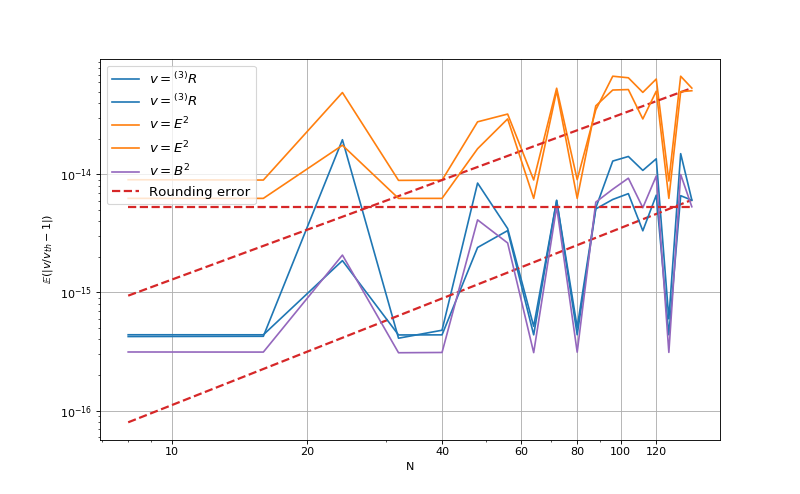

Text(0, 0.5, '$\\mathbb{E}\\left(|v/v_{th}-1|\\right)$')

In [3]:
iinc = -1


phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.loglog(allNs, meanerror_3R, label=r'$v={}^{(3)}R$')
yplot_4th_order_increase = [meanerror_3R[iinc]*((N/allNs[iinc])**1.5) for N in allNs]
plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2)

plt.loglog(allNs, meanerror_3Ri, 'C0', label=r'$v={}^{(3)}R$')

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_increase = [meanerror_E2[iinc]*((N/allNs[iinc])**1.4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2)

plt.loglog(allNs, meanerror_E2i, 'C1', label=r'$v=E^2$')

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_increase = [meanerror_B2[iinc]*((N/allNs[iinc])**0) for N in allNs]
plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2, label='Rounding error')

plt.legend(loc=2, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.xticks([10,20,40,60,80,100,120], ['10','20','40','60','80','100','120'])
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
#plt.savefig('Plots/BianchiII_Slicing_gamma=4d3.pdf')

In [4]:
import pandas as pd
data = np.array([allNs, meanerror_3R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '3R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/BianchiII_Slicing_gamma=4d3_128bit.csv')